In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
task_mapping = {
    "ioi": "IOI",
    "subject_verb": "Subject-Verb Agreement",
    "greater_than": "Greater Than",
}
palette = [
    "gray",  # neutral gray
    "#9d0208",  # burgundy (darkest red)
    "#d62828",  # deep red
    "#f94144",  # bright red
    "#ef476f",  # pinkish red
    "#e07a5f",  # terracotta
    "#f3722c",  # vivid orange
    "#f9844a",  # carrot orange
    "#f8961e",  # golden orange
    "#faa307",  # warm gold
    "#f9c74f",  # saffron (lightest in this range)
]

In [5]:
method = "attrib"
what = "completeness"
model = "pythia-160m"
is_topk = True
faith_dir = "/home/fbelotti/group-sae/faithfulness/pythia-160m_faithfulness_{}".format(
    "topk" if is_topk else "thr"
)
dfs = []
for task in ["subject_verb", "ioi", "greater_than"]:
    for cluster in ["Baseline"] + [f"K{i}" for i in range(1, 11)]:
        df = pd.read_csv(f"{faith_dir}/{model}_{task}_{cluster}_{method}_{what}.csv")
        df["cluster"] = cluster
        df["task"] = task
        dfs.append(df)
faith_df = pd.concat(dfs)
if not is_topk:
    faith_df["N_cut"] = pd.cut(faith_df["N"], 50)
    faith_df["N_cut"] = faith_df["N_cut"].apply(lambda x: x.mid)

In [6]:
grouped_df = (
    faith_df.groupby(["N" if is_topk else "N_cut", "cluster"])["score"].mean().reset_index()
)
grouped_df

,N,cluster,score
0,4.0,Baseline,0.392542
1,4.0,K1,0.480591
2,4.0,K10,0.396248
3,4.0,K2,0.451541
4,4.0,K3,0.389632
...,...,...,...
171,614.0,K5,0.033463
172,614.0,K6,0.026285
173,614.0,K7,0.033193
174,614.0,K8,0.005795


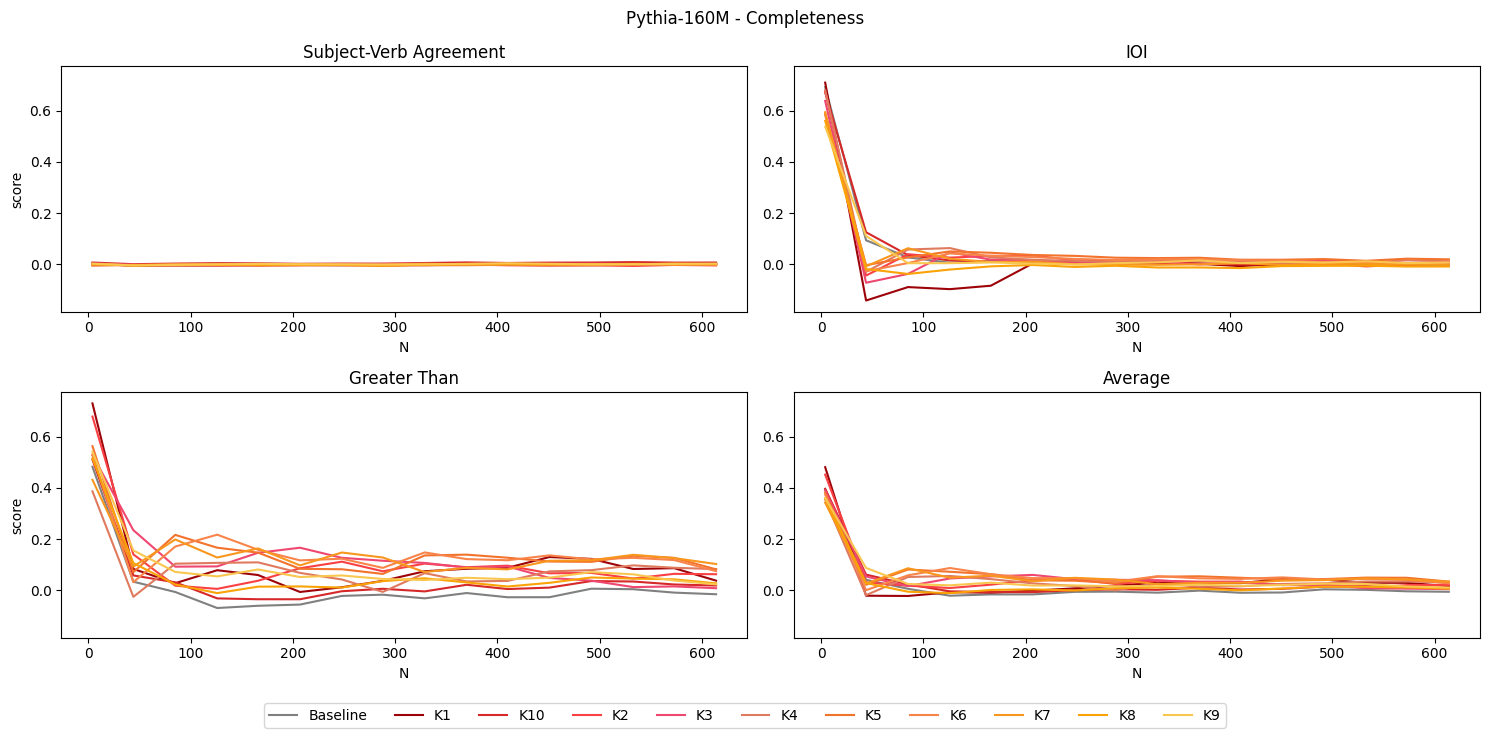

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharey=True)
for i, task in enumerate(["subject_verb", "ioi", "greater_than"]):
    ax = axes[i // 2, i % 2]
    sns.lineplot(
        data=faith_df[faith_df["task"] == task]
        .groupby(["N" if is_topk else "N_cut", "cluster"])["score"]
        .mean()
        .reset_index(),
        x="N" if is_topk else "N_cut",
        y="score",
        hue="cluster",
        palette=palette,
        ax=ax,
        legend=i == 0,
        # style="cluster",
    )
    ax.set_title(task_mapping[task])
    ax.yaxis.set_tick_params(labelbottom=True)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
ax = axes[1, 1]
sns.lineplot(
    data=grouped_df,
    x="N" if is_topk else "N_cut",
    y="score",
    hue="cluster",
    # style="cluster",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set_title("Average")
ax.yaxis.set_tick_params(labelbottom=True)
fig.suptitle(f"{model.title()} - {what.title()}")
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.0), ncol=11)
plt.tight_layout()